# Exercie 3: Comprendre la notion de surajustement et de sousajustement

Ce bloc-notes entraîne un modèle d'analyse des sentiments pour classer les critiques de films la base de données [ films Internet](https://www.imdb.com/) comme positives ou négatives , en fonction du texte de la critique. Il s'agit d'un exemple de classification binaire - ou à deux classes.

## Importation des bibliothèques

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import os, re, shutil, string
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, losses, utils, callbacks

## Téléchargement et extraction du jeu de données IMDB

In [15]:
# ce code télécharge et extrait le fichier "aclImdb_v1.tar.gz" à partir de l'URL spécifiée, puis stocke 
# le fichier téléchargé dans le répertoire actuel.
file_path = utils.get_file(
    fname = "db_imdb.tar.gz", 
    origin = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    extract=True, 
    archive_format='tar',
    cache_dir='.', 
    cache_subdir='')

In [16]:
file_path

'.\\db_imdb.tar.gz'

## Chemin du dossier du jeu de données

In [17]:
# ce code crée un chemin vers un répertoire en utilisant le répertoire parent du chemin spécifié dans file_path et en 
# ajoutant le répertoire "aclImdb" à la fin.
data_dir = Path(Path(file_path).parent, 'aclImdb')
data_dir.absolute()

WindowsPath('c:/Users/Methery/Documents/ai_ininahazwe_methery/TP1_2/aclImdb')

## Exploration du jeu de données

### Liste des fichiers et dossiers du jeu de données

In [18]:
[entry.name for entry in data_dir.iterdir()]

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

### Liste des fichiers et dossiers du jeu d'entraînement

In [19]:
train_dir = Path(data_dir, 'train')
print([entry.name for entry in train_dir.iterdir()])

['labeledBow.feat', 'neg', 'pos', 'unsup', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


### Liste des fichiers et dossiers du jeu de test

In [20]:
test_dir = Path(data_dir, 'test')
[entry.name for entry in test_dir.iterdir()]

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

### Affichage d'un commentaire du jeu d'entrainement

Les repertoires `aclImdb/train/pos` et `aclImdb/train/neg` contiennent de nombreux fichiers texte, dont chacun est une critique de film unique. Jetons un coup d'œil à l'un d'eux.

#### Nom des 5 premiers fichiers du repertoire des commentaires positifs

In [21]:
train_pos_dir = Path(train_dir, 'pos')
comment_pos = [entry.name for entry in train_pos_dir.iterdir()]
comment_pos[:5]

['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt']

#### Affichage du premier commentaire

In [22]:
with open(Path(train_pos_dir, comment_pos[0]).absolute()) as f:
    print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


## Chargement du jeu de données

### Suppresion du dossier `unsup` du jeu de données train

In [23]:
# La suppression évite de crée une troisième catégorie lors du chargement des données
shutil.rmtree(Path(train_dir, 'unsup').absolute())

### Chargement du jeu d'entrainement et validation

In [24]:
# Les données seront divisées en lots, et chaque lot aura (total exemple)/32 exemples.
batch_size = 32 

# Initialise le générateur de nombres aléatoires. Elle garantit que les résultats seront reproductibles, 
# c'est-à-dire que chaque fois que le code est exécuté avec la même valeur de seed, les résultats seront les mêmes.
seed = 42

In [25]:
# Ce code créer un jeu de données à partir d'un répertoire contenant des fichiers texte
raw_train_valid = utils.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size, 
    validation_split=0.2, # Pourcentage de données à utiliser pour la validation.
    subset='both', # La partie du jeu de données à charger "training" (par défaut), "validation".
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


Cela signifie qu'il y a un total de 25000 fichiers dans le répertoire spécifié, répartis en 2 classes différentes. Parmi ces fichiers, 20000 sont utilisés pour l'entraînement du modèle et 5000 fichiers sont utilisés pour la validation.

### Séparation des données d'entrînement et de validation

In [26]:
# raw_train_valid = List(_BatchDataset, _BatchDataset)
raw_train = raw_train_valid[0] # raw_train est le Jeu de données par lots (32 lots) _BatchDataset
raw_valid = raw_train_valid[1] # raw_valid est le Jeu de données par lots (32 lots) _BatchDataset

### Affichage du premier commentaire du premier lot

In [27]:
for text_batch, label_batch in raw_train.take(1):
    for label in label_batch:
        print(f"Etiquette: {int(label.numpy())}")
        break
    print("-------------------------------------")
    for text in text_batch:
        print(f"Texte: \n{text.numpy()}")
        break

Etiquette: 0
-------------------------------------
Texte: 
b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'


### Affichage des correspondance des classes

In [28]:
print("Etiquette 0 correspond à", raw_train.class_names[0])
print("Etiquette 1 correspond à", raw_train.class_names[1])

Etiquette 0 correspond à neg
Etiquette 1 correspond à pos


In [29]:
labels = ["négatif", "positif"]

Les étiquettes sont un tableau d'entiers, allant de 0 à 1.
 
| Etiquette       | Description   |
|-----------------|---------------|
| 0               | Négatif       |
| 1               | Positif       |


### Chargement du jeu de données de test

In [30]:
raw_test = utils.text_dataset_from_directory(
    directory=test_dir,
    batch_size=batch_size, 
)

Found 25000 files belonging to 2 classes.


Cela signifie qu'il y a un total de 25000 fichiers dans le répertoire spécifié, répartis en 2 classes différentes.

### Détail des 3 ensembles de données

#### Détail du jeu d'entrainement

In [31]:
train_label = []
for text_batch, label_batch in raw_train:
    for label in label_batch:
        train_label.append(label.numpy())
        
print(f"Le jeu d'entrainement contient {batch_size} lots, et chaque lot contient {len(raw_train)} commentaires, "
     f"ce qui fait un total {len(train_label)} commentaires.")

print()
# Compter le nombre de commentaire pour chaque étiquette du jeu d'entraînement
train_label_distinct = pd.Series(train_label).value_counts()
for i in range(0, len(train_label_distinct.array)):
    print(f"- {train_label_distinct[i]} commentaires avec l'étiquette '{labels[i]}'")

Le jeu d'entrainement contient 32 lots, et chaque lot contient 625 commentaires, ce qui fait un total 20000 commentaires.

- 10038 commentaires avec l'étiquette 'négatif'
- 9962 commentaires avec l'étiquette 'positif'


#### Détail du jeu de validation

In [32]:
valid_label = []
for text_batch, label_batch in raw_valid:        
    for label in label_batch:
        valid_label.append(label.numpy())
        
print(f"Le jeu d'entrainement contient {batch_size} lots, et chaque lot contient {len(raw_valid)} commentaires, "
     f"ce qui fait un total {len(valid_label)} commentaires.")

print()
# Compter le nombre de commentaire pour chaque étiquette du jeu de validation
valid_label_distinct = pd.Series(valid_label).value_counts()
for i in range(0, len(valid_label_distinct.array)):
    print(f"- {valid_label_distinct[i]} commentaires avec l'étiquette '{labels[i]}'")

Le jeu d'entrainement contient 32 lots, et chaque lot contient 157 commentaires, ce qui fait un total 5000 commentaires.

- 2462 commentaires avec l'étiquette 'négatif'
- 2538 commentaires avec l'étiquette 'positif'


#### Détail du jeu de test

In [33]:
test_label = []
for text_batch, label_batch in raw_test: 
    for label in label_batch:
        test_label.append(label.numpy())
        
print(f"Le jeu d'entrainement contient {batch_size} lots, et chaque lot contient {len(raw_test)} commentaires, "
     f"ce qui fait un total {len(test_label)} commentaires.")

print()
# Compter le nombre de commentaire pour chaque étiquette du jeu de test
test_label_distinct = pd.Series(test_label).value_counts()
for i in range(0, len(test_label_distinct.array)):
    print(f"- {test_label_distinct[i]} commentaires avec l'étiquette '{labels[i]}'")

Le jeu d'entrainement contient 32 lots, et chaque lot contient 782 commentaires, ce qui fait un total 25000 commentaires.

- 12500 commentaires avec l'étiquette 'négatif'
- 12500 commentaires avec l'étiquette 'positif'


#### Remarque

In [34]:
# Somme des valeurs distinctes d'apprentissage et de validation
train_valid_distinct = train_label_distinct + valid_label_distinct
for i in range(0, len(train_valid_distinct.array)):
    print(f"- {train_valid_distinct[i]} commentaires avec l'étiquette '{labels[i]}'")

- 12500 commentaires avec l'étiquette 'négatif'
- 12500 commentaires avec l'étiquette 'positif'


Les ensembles de formation et de test sont équilibrés , ce qui signifie qu'ils contiennent un nombre égal d'avis positifs et négatifs.

## Prétraitement des données

### Définition de fonctions utilitaires

In [35]:
def standardization(data):
    """
    Cette fonction réalise une normalisation du texte en effectuant les étapes suivantes:
    
    - Conversion en minuscules (lowercase) de toutes les caractères du texte.
    - Suppression des balises HTML "<br />" et remplacement par un espace.
    - Suppression de la ponctuation en utilisant une expression régulière.
    
    Paramètres:
    -----------
    data : tensorflow.Tensor
        Le texte à normaliser.
    
    Retour:
    -------
    tensorflow.Tensor
        Le texte normalisé.
    """
    lowercase = tf.strings.lower(data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, f'[{re.escape(string.punctuation)}]','')



def vectorize_text(text, label):
    """
    Cette fonction prend en entrée un texte et une étiquette, puis effectue les opérations suivantes :
    
    - Utilise la fonction `tensorflow.expand_dims` pour ajouter une dimension à la fin du texte.
    - Applique la couche de vectorisation `vectorize_layer` au texte pour le convertir en une séquence d'entiers.
    
    Paramètres :
    -----------
    text : tensorflow.Tensor
        Le texte à vectoriser.
    
    Retour :
    -------
    tensorflow.Tensor, tensorflow.Tensor
        Le texte vectorisé.
    """
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label # vectorizer([phrase])

### Configure d'une couche de vectorisation

In [36]:
# Ce code configure une couche de vectorisation de texte qui prendra en compte au maximum 10 000 caractéristiques 
# différentes (tokens) et qui transformera les séquences de texte en vecteurs de longueur 250.

# Il s'agit du nombre maximum de jetons (mots ou caractères) à conserver lors de la vectorisation. Les max_tokens 
# jetons les plus fréquents seront conservés, et les autres seront ignorés.
max_features = 10000 

# Il s'agit de la longueur de la séquence de sortie. Les séquences plus courtes que output_sequence_length seront 
# remplies avec des zéros à la fin, tandis que les séquences plus longues seront tronquées.
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=max_features,
    output_mode='int', # la sortie sera une séquence d'entiers représentant les jetons du texte.
    output_sequence_length=sequence_length)

### Création d'un jeu de données uniquement textuel (sans étiquettes)

In [37]:
train_text = raw_train.map(lambda x_batch, y_batch: x_batch)

### Adaptation de la couche de vectorisation aux données d'entraînement

In [38]:
# La méthode adapt() est utilisée pour calculer les statistiques nécessaires à la vectorisation des données. 
# Elle analyse les données d'entraînement et détermine les caractéristiques nécessaires pour effectuer la 
# transformation. Cela peut inclure la création d'un vocabulaire de mots uniques, le calcul de la fréquence des mots, etc.
vectorize_layer.adapt(train_text)

### Exemple de vectorisation

In [39]:
text_batch, label_batch = next(iter(raw_train))
first_review, first_label = text_batch[0], label_batch[0]
text_vectorized = vectorize_text(first_review, first_label)

print(f"Etiquette: {labels[int(first_label.numpy())]} \n")
print(f"Commentaire: \n{first_review.numpy()}\n")
print(f"Commentaire vectorisé: \n{text_vectorized}")

Etiquette: négatif 

Commentaire: 
b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'

Commentaire vectorisé: 
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,   86, 101

### Vérification de la correspondence jeton du texte et entier dans le tabelau de vectorisation

In [40]:
vocabular = vectorize_layer.get_vocabulary() # Vocabulaire utilisé par la couche de vectorisation vectorize_layer
index = text_vectorized[0][0][4] # Récupère l'index du cinquième mot dans le texte vectorisé text_vectorized

# Affiche le mot correspondant à l'index dans le vocabulaire
print(f"Le mot '{vocabular[index]}' correspond au nombre {index}")

Le mot 'cop' correspond au nombre 1021


### Vectorisation des jeux de données d'apprentissage, de validation et de test

In [41]:
train_vect = raw_train.map(vectorize_text)
valid_vect = raw_valid.map(vectorize_text)
test_vect = raw_test.map(vectorize_text)

## Configurer l'ensemble de données pour les performances

In [42]:
# Ce code optimise le chargement et la préparation des données en mettant en cache les données en mémoire et en 
# préchargeant les données en arrière-plan. Cela permet d'accélérer l'entraînement et l'évaluation des modèles 
# d'apprentissage automatique en réduisant les temps d'attente pour les données.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_vect.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = valid_vect.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_vect.cache().prefetch(buffer_size=AUTOTUNE)

## Construction du modèle

### Mise en palce des couches

In [43]:
# la couche d'embedding est utilisée pour convertir des entiers représentant des mots en vecteurs denses de taille 
# embedding_dim. La valeur max_features + 1 représente le nombre total de mots possibles dans le vocabulaire.

embedding_dim = 16 # chaque entiers de mot sera représenté par un vecteur de dimension 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim), # représentation vectorielle dense d'un mot
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(), # Reduction de dimension
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

### Configuration du model

In [44]:
# Ce code compile le modèle en spécifiant la fonction de perte, l'optimiseur et les métriques à 
# utiliser lors de l'apprentissage. La fonction de perte "BinaryCrossentropy" est utilisée pour évaluer la différence 
# entre les prédictions et les valeurs réelles, l'optimiseur "adam" est utilisé pour ajuster les poids du modèle, et 
# la métrique "BinaryAccuracy" est utilisée pour évaluer les performances du modèle pendant l'entraînement.

# L'argument from_logits=True indique que les prédictions du modèle ne sont pas normalisées et doivent être transformées en 
# probabilités à l'aide d'une fonction d'activation appropriée.

# L'argument threshold=0.0 spécifie le seuil utilisé pour déterminer si une prédiction est considérée comme 
# positive ou négative
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Ajustement du modèle

In [45]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10


625/625 [==============================] - 9s 13ms/step - loss: 0.6615 - binary_accuracy: 0.6930 - val_loss: 0.6106 - val_binary_accuracy: 0.7756
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5443 - binary_accuracy: 0.8033 - val_loss: 0.4949 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4415 - binary_accuracy: 0.8456 - val_loss: 0.4179 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3763 - binary_accuracy: 0.8673 - val_loss: 0.3722 - val_binary_accuracy: 0.8586
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3337 - binary_accuracy: 0.8797 - val_loss: 0.3443 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3031 - binary_accuracy: 0.8900 - val_loss: 0.3252 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 

### Evaluation du modèle

In [46]:
loss, accuracy = model.evaluate(test_ds)

print("Perte: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 1:40 - loss: 0.2714 - binary_accuracy: 0.9062

782/782 [==============================] - 7s 9ms/step - loss: 0.3099 - binary_accuracy: 0.8732
Perte:  0.309900164604187
Accuracy:  0.8731600046157837


## Créer un graphique de précision et de perte

In [47]:
# La variable history_dict est un dictionnaire qui contient les métriques et les pertes du modèle lors de l'apprentissage
# (tout ce qui s'est passé pendant l'entraînement)
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [48]:
_epochs = range(1, epochs + 1)

### Graphique de perte de formation et de validation 

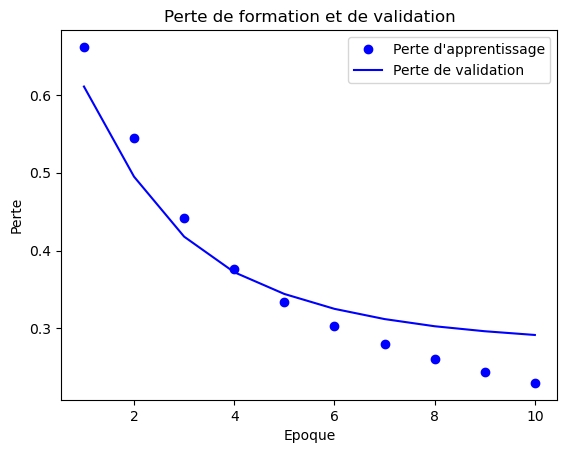

In [49]:
plt.plot(_epochs, history_dict['loss'], 'bo', label="Perte d'apprentissage")
plt.plot(_epochs, history_dict['val_loss'], 'b', label='Perte de validation')
plt.title('Perte de formation et de validation')
plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.legend()
plt.show()

### Graphique de la précision de la formation et de la validation 

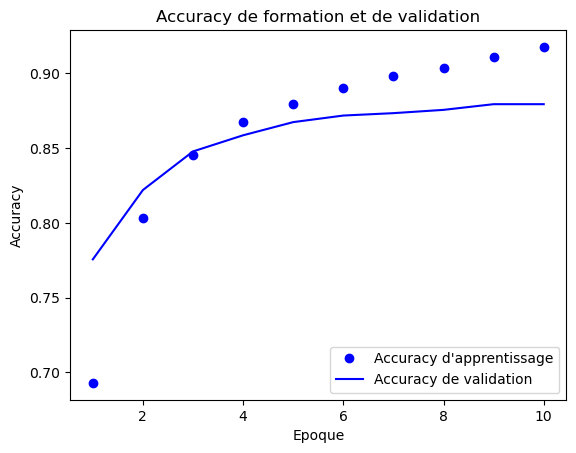

In [50]:
plt.plot(_epochs, history_dict['binary_accuracy'], 'bo', label="Accuracy d'apprentissage")
plt.plot(_epochs, history_dict['val_binary_accuracy'], 'b', label='Accuracy de validation')
plt.title('Accuracy de formation et de validation')
plt.xlabel('Epoque')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Dans ce graphique, les points représentent la perte d'apprentissage et la précision, et les lignes pleines représentent la perte de validation et la précision.

Il est important de noter que la perte d'apprentissage diminue à chaque époque, tandis que la précision de l'apprentissage augmente. Cela est prévu lorsqu'on utilise une optimisation par descente de gradient, car elle vise à minimiser la quantité souhaitée à chaque itération.

Cependant, ce n'est pas le cas pour la perte de validation et la précision. Elles semblent atteindre leur maximum avant la précision de l'apprentissage. Cela est un exemple de surajustement, où le modèle performe mieux sur les données d'apprentissage que sur des données qu'il n'a jamais vues auparavant. Après ce point, le modèle sur-optimise et apprend des représentations spécifiques aux données d'apprentissage qui ne se généralisent pas aux données de test.

## Arrêtons le modèle avant qui'il soit mauvais

Le surajustement en arrêtant simplement l'entraînement lorsque la précision de la validation n'augmente plus. Une façon de le faire est d'utiliser le rappel tf.keras.callbacks.EarlyStopping.
Le rappel anticipé tf.keras.callbacks.EarlyStopping est utilisé dans TensorFlow pour arrêter l'entraînement 
d'un modèle de réseau neuronal plus tôt si une certaine condition est remplie.

In [51]:
model2 = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model2.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Créer une instance du rappel EarlyStopping
# ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
# L'entraînement s'arrêtera prématurément si la perte de validation ne s'améliore pas pendant 3 époques consécutives
# restore_best_weights : Indique si les poids du modèle doivent être restaurés à partir de l'époque ayant la meilleure 
# valeur de la quantité surveillée
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

Epoch 1/30


625/625 [==============================] - 4s 5ms/step - loss: 0.6640 - binary_accuracy: 0.6911 - val_loss: 0.6144 - val_binary_accuracy: 0.7754
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 0.5481 - binary_accuracy: 0.8005 - val_loss: 0.4980 - val_binary_accuracy: 0.8202
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 0.4451 - binary_accuracy: 0.8432 - val_loss: 0.4200 - val_binary_accuracy: 0.8474
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3786 - binary_accuracy: 0.8658 - val_loss: 0.3739 - val_binary_accuracy: 0.8594
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3351 - binary_accuracy: 0.8788 - val_loss: 0.3452 - val_binary_accuracy: 0.8676
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3048 - binary_accuracy: 0.8887 - val_loss: 0.3259 - val_binary_accuracy: 0.8712
Epoch 7/30
625/625 [==============================] - 3s 5ms/step - loss: 0

In [52]:
loss2, accuracy2 = model2.evaluate(test_ds)

print("Perte: ", loss2)
print("Accuracy: ", accuracy2)

 50/782 [>.............................] - ETA: 1s - loss: 0.3191 - binary_accuracy: 0.8706

782/782 [==============================] - 1s 2ms/step - loss: 0.3091 - binary_accuracy: 0.8739
Perte:  0.3091263175010681
Accuracy:  0.8739200234413147


## Ajoutons la couche de vectorisation pour faciliter l'exportation

In [53]:
# Nous allons ajouter la couche TextVectorization à notre modèle pour le rendre capable 
# de traiter des chaînes brutes directement.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy'])

loss3, accuracy3 = export_model.evaluate(raw_test)
print(accuracy3)

782/782 [==============================] - 8s 10ms/step - loss: 0.3099 - accuracy: 0.8732
0.8731600046157837


## Inférence sur de nouvelles données

In [54]:
# On test le modèle sur de nouvelle données de chaine brutes
examples = [
  "The movie was great! <br /> \"",
  "The movie was okay.",
  "The movie was terrible...", 
    b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, '
    b'I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", '
    b'"High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. '
    b'"Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting '
    b'there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the '
    b'film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s '
    b'all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of '
    b'a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
]

export_model.predict(examples)

1/1 [==============================] - 0s 168ms/step


array([[0.66029084],
       [0.4884203 ],
       [0.40167937],
       [0.8335075 ]], dtype=float32)

## Modification de la taille du reseau

In [55]:
embedding_dim = 64 
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim), 
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(), 
  layers.Dropout(0.3),
  layers.Dense(1)])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
model.fit(train_ds, validation_data=val_ds, epochs=20)

print("On remarque que le temps d'exécution est beaucoup long avec l'augementation de la dimension "
      "de la representation vectorielle dense des mots.")

Epoch 1/20
625/625 [==============================] - 10s 15ms/step - loss: 0.6252 - binary_accuracy: 0.7149 - val_loss: 0.5249 - val_binary_accuracy: 0.8018
Epoch 2/20
625/625 [==============================] - 10s 15ms/step - loss: 0.4352 - binary_accuracy: 0.8418 - val_loss: 0.3883 - val_binary_accuracy: 0.8534
Epoch 3/20
625/625 [==============================] - 10s 16ms/step - loss: 0.3369 - binary_accuracy: 0.8751 - val_loss: 0.3364 - val_binary_accuracy: 0.8670
Epoch 4/20
625/625 [==============================] - 10s 16ms/step - loss: 0.2877 - binary_accuracy: 0.8920 - val_loss: 0.3116 - val_binary_accuracy: 0.8738
Epoch 5/20
625/625 [==============================] - 10s 15ms/step - loss: 0.2547 - binary_accuracy: 0.9065 - val_loss: 0.2987 - val_binary_accuracy: 0.8782
Epoch 6/20
625/625 [==============================] - 10s 16ms/step - loss: 0.2300 - binary_accuracy: 0.9144 - val_loss: 0.2917 - val_binary_accuracy: 0.8802
Epoch 7/20
625/625 [==============================] 

In [56]:
embedding_dim = 2
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(), 
  layers.Dropout(0.3),
  layers.Dense(1)])

epochs=20
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.fit(train_ds, validation_data=val_ds, epochs=20)

print("On remarque que le temps d'exécution est beaucoup très rapide avec la dimunition de la dimension "
      "de la representation vectorielle dense des mots.")

Epoch 1/20


625/625 [==============================] - 3s 4ms/step - loss: 0.6867 - binary_accuracy: 0.6359 - val_loss: 0.6767 - val_binary_accuracy: 0.7534
Epoch 2/20
625/625 [==============================] - 2s 4ms/step - loss: 0.6603 - binary_accuracy: 0.7230 - val_loss: 0.6439 - val_binary_accuracy: 0.7680
Epoch 3/20
625/625 [==============================] - 2s 4ms/step - loss: 0.6242 - binary_accuracy: 0.7530 - val_loss: 0.6058 - val_binary_accuracy: 0.7904
Epoch 4/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5857 - binary_accuracy: 0.7654 - val_loss: 0.5680 - val_binary_accuracy: 0.8084
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5498 - binary_accuracy: 0.7899 - val_loss: 0.5327 - val_binary_accuracy: 0.8212
Epoch 6/20
625/625 [==============================] - 2s 4ms/step - loss: 0.5185 - binary_accuracy: 0.8011 - val_loss: 0.5015 - val_binary_accuracy: 0.8292
Epoch 7/20
625/625 [==============================] - 2s 4ms/step - loss: 0

## Modifions les paramètres pour montrer le surapprentissage

In [57]:
embedding_dim = 64 
model3 = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
#   layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
#   layers.Dropout(0.1),
  layers.Dense(1)])

epochs=20
model3.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


625/625 [==============================] - 7s 10ms/step - loss: 0.6070 - binary_accuracy: 0.7290 - val_loss: 0.4901 - val_binary_accuracy: 0.8138
Epoch 2/20
625/625 [==============================] - 6s 10ms/step - loss: 0.4004 - binary_accuracy: 0.8528 - val_loss: 0.3634 - val_binary_accuracy: 0.8610
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.3095 - binary_accuracy: 0.8849 - val_loss: 0.3202 - val_binary_accuracy: 0.8726
Epoch 4/20
625/625 [==============================] - 6s 10ms/step - loss: 0.2628 - binary_accuracy: 0.9022 - val_loss: 0.3008 - val_binary_accuracy: 0.8784
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2309 - binary_accuracy: 0.9153 - val_loss: 0.2917 - val_binary_accuracy: 0.8808
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2062 - binary_accuracy: 0.9244 - val_loss: 0.2884 - val_binary_accuracy: 0.8810
Epoch 7/20
625/625 [==============================] - 6s 10ms/step - 

In [58]:
_epochs3 = range(1, epochs + 1)
history3_dict = history3.history
history3_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

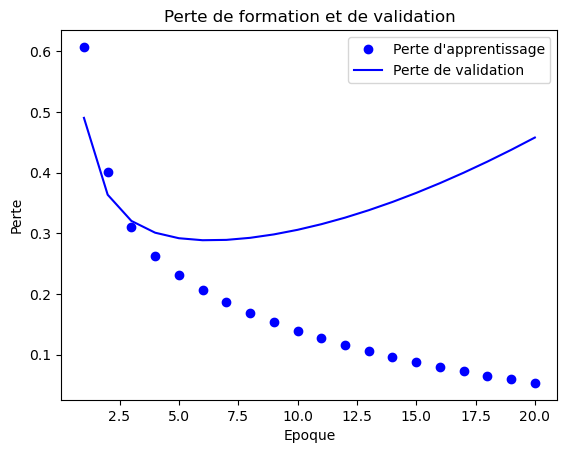

In [59]:
plt.plot(_epochs3, history3_dict['loss'], 'bo', label="Perte d'apprentissage")
plt.plot(_epochs3, history3_dict['val_loss'], 'b', label='Perte de validation')
plt.title('Perte de formation et de validation')
plt.xlabel('Epoque')
plt.ylabel('Perte')
plt.legend()
plt.show()

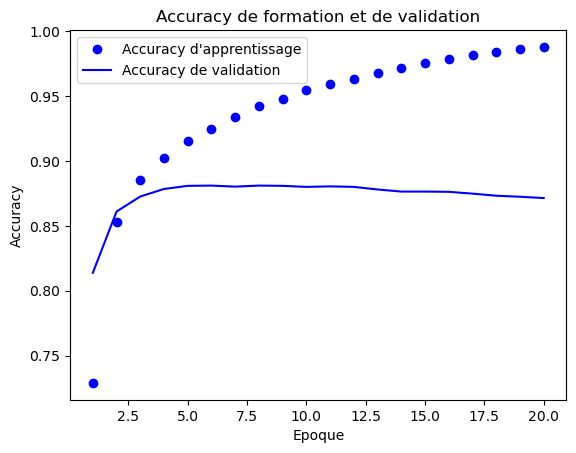

In [60]:
plt.plot(_epochs3, history3_dict['binary_accuracy'], 'bo', label="Accuracy d'apprentissage")
plt.plot(_epochs3, history3_dict['val_binary_accuracy' ], 'b', label='Accuracy de validation')
plt.title('Accuracy de formation et de validation')
plt.xlabel('Epoque')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

On observe un surapprentissage du modèle. Nous avons supprimé les couches de dropout et augmenté la taille de dimension du vecteur représentant les mots du vocabulaire.